# Automated Annual Medical Expenditure Estimator

## Problem Statement


>  ACME Insurance Inc. offers affordable health insurance to thousands of customers throughout the United States. As the lead data scientist at ACME, **I am tasked with creating an automated system to estimate the annual medical expenditure for new customers**, using information such as their age, sex, BMI, children, smoking habits, and region of residence. 
>
> Estimates from this system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, this work must explain why the system outputs a certain prediction.
> 
> This work uses data from  'https://www.kaggle.com/datasets/tamirat2022/annual-medical-expenditure' containing verified historical data, consisting of the aforementioned information and the actual medical charges incurred by over 1300 customers. 




## major tasks


>  Downloading the data set
> 
>  Preprocessing the data set
> 
>  Model development and evaluation
> 
>  Prediction
> 
>  Saving the trained model,important processed data sets and important objects

In [1]:
#Important libraries to avoid long warning displays
import warnings
warnings.filterwarnings('ignore')

## Downloading the Data

In [107]:
# Liberaries for importing, Exploratory Data Analysis and Data Preprocessing
import opendatasets as od
import os
import pandas as pd
import numpy as np

In [13]:
dataset_url = 'https://www.kaggle.com/datasets/tamirat2022/annual-medical-expenditure'
od.download(dataset_url)

Skipping, found downloaded files in ".\annual-medical-expenditure" (use force=True to force download)


Once the above command is executed, the dataset is downloaded and extracted to the the directory annual-medical-expenditure.

In [122]:
data_dir = './annual-medical-expenditure'
os.listdir(data_dir)

['medical.csv']

In [123]:
train_csv = data_dir + '/medical.csv'

We can now create a Pandas dataframe using the downloaded file, to view and analyze the data.

In [124]:
medical_df = pd.read_csv(train_csv)
medical_df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [7]:
medical_df.shape

(1338, 7)

The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer. 

Let's check the data type for each column.

In [18]:
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like "age", "children", "bmi" ([body mass index](https://en.wikipedia.org/wiki/Body_mass_index)) and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values, which saves us a fair bit of work!

Here are some statistics for the numerical columns:

In [19]:
medical_df.describe()

age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.



## Exploratory Analysis and Visualization

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.



let's import packages for visualization

In [8]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The following settings will improve the default style and font sizes for our charts.

In [9]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [16]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

In [10]:
fig = px.histogram(medical_df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the [number of people of any given age](https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/) (between 18 & 64) in the USA.


### Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

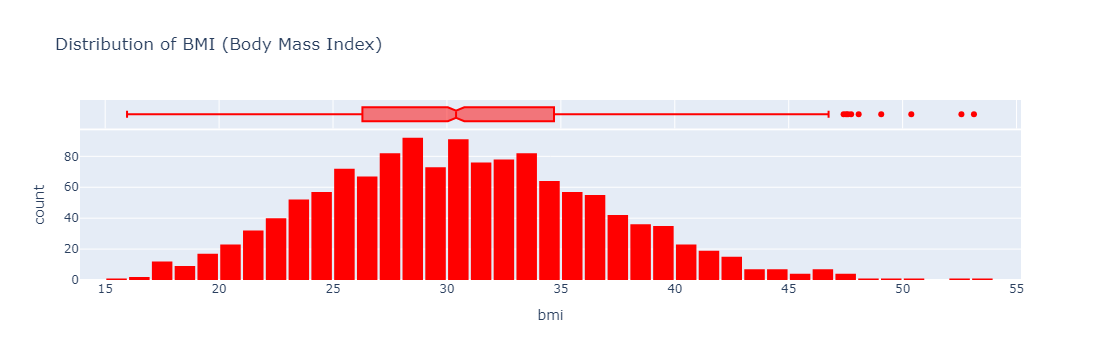

In [42]:
fig = px.histogram(medical_df, 
                   x='bmi', 
                   marginal='box', 
                   color_discrete_sequence=['red'], 
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

The measurements of body mass index seem to form a [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) centered around the value 30, with a few outliers towards the right. Here's how BMI values can be interpreted ([source](https://study.com/academy/lesson/what-is-bmi-definition-formula-calculation.html)):

![](https://i.imgur.com/lh23OiY.jpg)


### Charges

Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

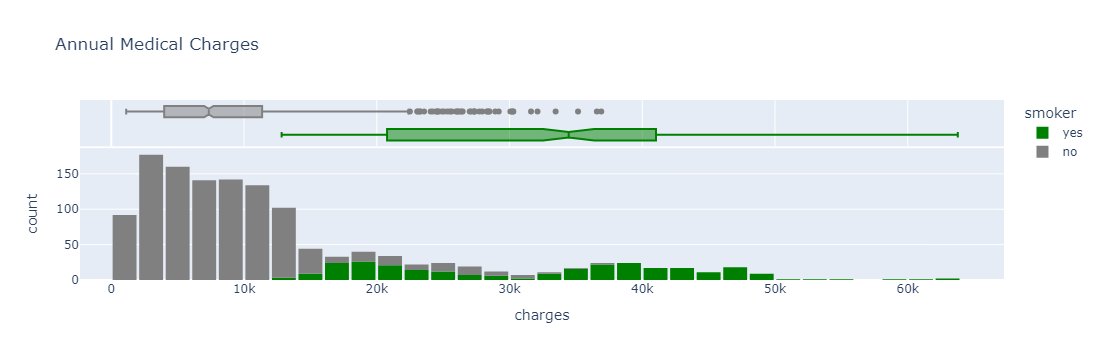

In [43]:
fig = px.histogram(medical_df, 
                   x='charges', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

We can make the following observations from the above graph:

* For most customers, the annual medical charges are under \\$10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
* There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \\$7300, the median for smokers is close to \\$35,000.



### Smoker

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [44]:
medical_df.smoker.value_counts(normalize=True)

smoker
no     0.795217
yes    0.204783
Name: proportion, dtype: float64

In [21]:
px.histogram(medical_df, x='smoker', color='sex', title='Smoker')

It appears that 20% of customers have reported that they smoke. 


**Having looked at individual columns, we can now visualize the relationship between "charges" (the value we wish to predict) and other columns.**

### Age and Charges

Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

In [22]:
fig = px.scatter(medical_df, 
                 x='age', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='Age vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

We can make the following observations from the above chart:

* The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.


* We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

     1. The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others
     
     2. The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".
     
     3. The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.
     


### BMI and Charges

Let's visualize the relationship between BMI (body mass index) and charges using another scatter plot. Once again, we'll use the values from the "smoker" column to color the points.

In [23]:
fig = px.scatter(medical_df, 
                 x='bmi', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.

What other insights can you gather from the above graph?

### Correlation

As you can tell from the analysis, the values in some columns are more closely related to the values in "charges" compared to other columns. E.g. "age" and "charges" seem to grow together, whereas "bmi" and "charges" don't.

This relationship is often expressed numerically using a measure called the _correlation coefficient_, which can be computed using the `.corr` method of a Pandas series.

In [45]:
medical_df.charges.corr(medical_df.age)

0.29900819333064765

In [25]:
medical_df.charges.corr(medical_df.bmi)

0.19834096883362895

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [48]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_values)
medical_df.charges.corr(smoker_numeric)

0.7872514304984772

### **Correlation_interpretation**
**[Source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/)**

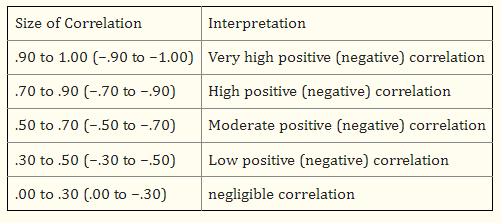

Pandas dataframes also provide a `.corr` method to compute the correlation coefficients between all pairs of numeric columns.

In [53]:
medical_df.corr(numeric_only=True)

age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000

The result of `.corr` is called a correlation matrix and is often visualized using a heatmap.

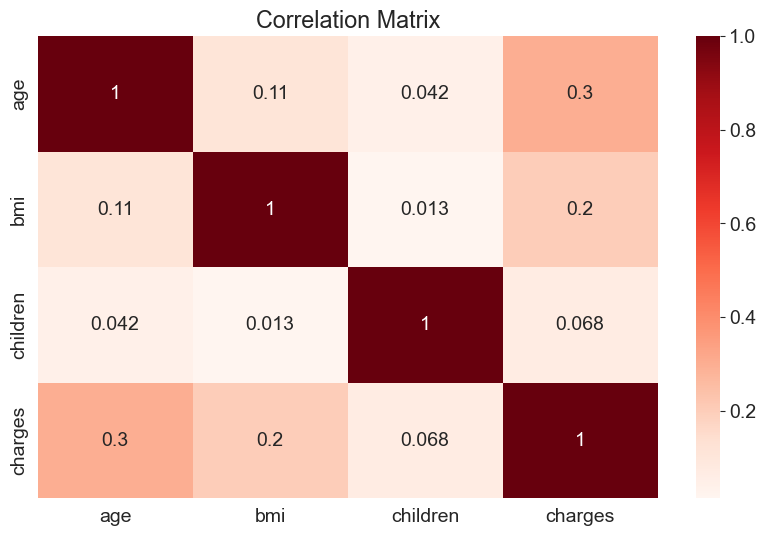

In [54]:
sns.heatmap(medical_df.corr(numeric_only=True), cmap='Reds', annot=True)
plt.title('Correlation Matrix');

## Linear Regression using a Single Feature

We can see that the "age" column has the strongest correlation with "charges" among the numerical features. Let's try to estimate the value of "charges" using the value of "age".

### Model

$y = wx + b$

The line is characterized two numbers: $w$ (called "slope") and $b$ (called "intercept"). 



In the above case, the x axis shows "age" and the y axis shows "charges". Thus, we're assuming the following relationship between the two:

$charges = w \times age + b$

We'll try determine $w$ and $b$ for the line that best fits the data. 

* This technique is called _linear regression_, and we call the above equation a _linear regression model_, because it models the relationship between "age" and "charges" as a straight line. 

* The numbers $w$ and $b$ are called the _parameters_ or _weights_ of the model.

* The values in the "age" column of the dataset are called the _inputs_ to the model and the values in the charges column are called "targets". 

Let define a helper function `estimate_charges`, to compute $charges$, given $age$, $w$ and $b$.


## Import Important liberaries

In [40]:
#importing Libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,root_mean_squared_error

### Create and fit the model

**For this work, we will use the whole data to train and evaluete the model**

In [41]:
# lets extract the input and target data
inputs,targets  = medical_df[['age']], medical_df.charges

In [56]:
#train_test splitting
train_in,test_in, train_tar,test_tar = train_test_split(inputs,targets , test_size=0.2, random_state=42)

we create a new model object and optimize it to find the best fit line for the inputs and targets.

In [59]:
model = LinearRegression().fit(train_in, train_tar)

### parameters

In [58]:
# Coefficient
w=model.coef_
print(w)

# Intercept
b=model.intercept_
print(b)

[240.59655979]
3876.928684191691


### make predictions

We can now make predictions using the model. Let's try predicting the charges for the ages 23, 37 and 61

In [60]:
model.predict(np.array([[23], [37], [61]]))

array([ 9410.64955933, 12779.00139638, 18553.31883131])

### **Performance Evaluation**

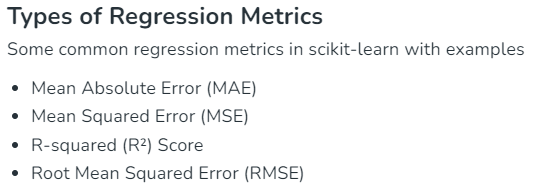

[Source](https://www.geeksforgeeks.org/regression-metrics/)

In [64]:
# prediction for the whole input
predictions=model.predict(train_in)
rmse= root_mean_squared_error(train_tar, predictions)
r2= r2_score(train_tar, predictions)
print('training data performance')
print('RMSE = {:.2f} \nr2_score = {:.0f}%'.format(rmse,r2*100))

training data performance
RMSE = 11527.29 
r2_score = 8%


In [65]:
# prediction for the whole input
predictions=model.predict(test_in)
rmse= root_mean_squared_error(test_tar, predictions)
r2= r2_score(test_tar, predictions)
print('training data performance')
print('RMSE = {:.2f} \nr2_score = {:.0f}%'.format(rmse,r2*100))

training data performance
RMSE = 11661.22 
r2_score = 12%


**The predicted value is off by 11527 on average from the actual value for the training data and the reason is there are almost three clusters and the model is trying to fit the overall data**

**age explains about 8% of variance in the charges variable for the training data.** 

>The performance measure of the training and test data shows that the model is generalizes well for the previosly unseen data.

**Visualize the model**

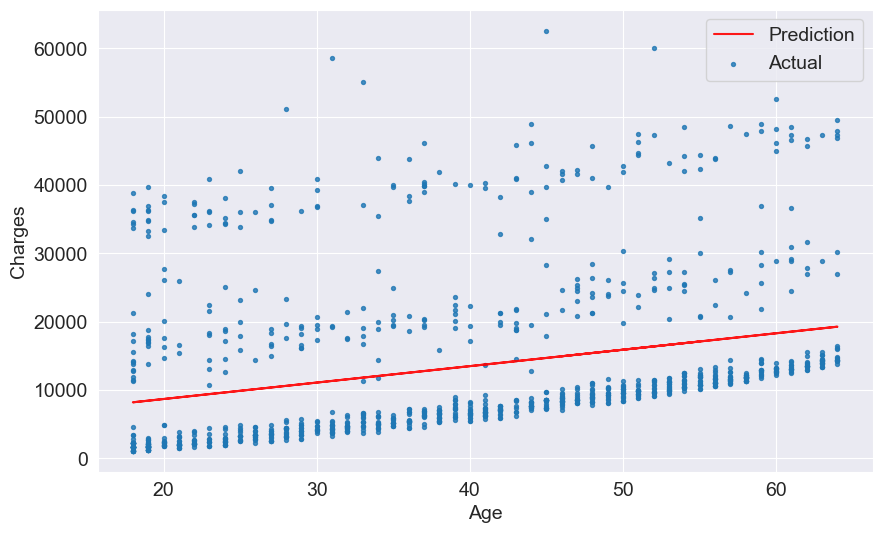

In [92]:
predictions=model.predict(train_in)
plt.plot(train_in, predictions, 'r', alpha=0.9);
plt.scatter(train_in, train_tar, s=8,alpha=0.8);
plt.xlabel('Age');
plt.ylabel('Charges')
plt.legend(['Prediction', 'Actual']);

**As can be seen from the visualization, the model tries to consider the two outlier clusters.**

## Linear Regression using Multiple Features

### Encode catagorical columns with  binary category

In [125]:
medical_df['sex']= medical_df['sex'].map({'female':0,'male':1})
medical_df['smoker']= medical_df['smoker'].map({'no':0,'yes':1})

## Training, Validation and Test Sets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using an optimization technique. 


2. **Validation set** - used to evaluate the model during training, tune model hyperparameters (optimization technique, regularization etc.), and pick the best version of the model. Picking a good validation set is essential for training models that generalize well. [Learn more here.](https://www.fast.ai/2017/11/13/validation-sets/)


3. **Test set** - used to compare different models or approaches and report the model's final accuracy. For many datasets, test sets are provided separately. The test set should reflect the kind of data the model will encounter in the real-world, as closely as feasible.


<img src="https://i.imgur.com/j8eITrK.png" width="480">


As a general rule of thumb you can use around 60% of the data for the training set, 20% for the validation set and 20% for the test set. If a separate test set is already provided, you can use a 75%-25% training-validation split.




In [133]:
train_val_df, test_df = train_test_split(medical_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [134]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (802, 7)
val_df.shape : (268, 7)
test_df.shape : (268, 7)


**For this work, as the data set is small in size and we are not going to compare different models, let the dat be grouped in to train and test data set. to train and measure the acuracy of the multiple linear regression.**

In [126]:
train_df, test_df = train_test_split(medical_df, test_size=0.2, random_state=42)

In [112]:
train_df.shape

(1070, 7)

In [113]:
test_df.shape

(268, 7)

**Identify input and target columns**

In [127]:
input_cols=['age','sex','bmi','children','smoker','region']	
target_col='charges'

**Identify the data for training and evalution**

In [128]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [129]:
train_inputs.head()

age  sex    bmi  children  smoker     region
560    46    0  19.95         2       0  northwest
1285   47    0  24.32         0       0  northeast
1142   52    0  24.86         0       0  southeast
969    39    0  34.32         5       0  southeast
486    54    0  21.47         3       0  northwest

In [223]:
train_targets.head()

560      9193.83850
1285     8534.67180
1142    27117.99378
969      8596.82780
486     12475.35130
Name: charges, dtype: float64

**List of columns**

In [28]:
medical_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

**Numeric and catagorical columns**

In [130]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [131]:
#numeric columns
numeric_cols

['age', 'sex', 'bmi', 'children', 'smoker']

In [132]:
categorical_cols

['region']

## Imputing Missing Numeric Data

In [226]:
#check for nulls in the data frame
medical_df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

**The data set contains no nulls, so no imputing process is required. let we develop an imputer in case the future input data contains nulls.**

In [133]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')
imputer.fit(medical_df[numeric_cols])

SimpleImputer()

## Scaling Numeric Features

It involves bringing all the features to a similar scale, so that no single feature dominates the learning algorithm. Optimization algorithms also work better in practice with smaller numbers.

The numeric columns in our dataset have varying ranges.

In [134]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(medical_df[numeric_cols])

MinMaxScaler()

In [156]:
print('Minimum:')
list(scaler.data_min_)

Minimum:


[18.0, 0.0, 15.96, 0.0, 0.0]

In [37]:
print('Maximum:')
list(scaler.data_max_)

Maximum:


[64.0, 53.13, 5.0]

In [135]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])

test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [136]:
train_inputs.head()

age  sex       bmi  children  smoker     region
560   0.608696  0.0  0.107345       0.4     0.0  northwest
1285  0.630435  0.0  0.224913       0.0     0.0  northeast
1142  0.739130  0.0  0.239440       0.0     0.0  southeast
969   0.456522  0.0  0.493947       1.0     0.0  southeast
486   0.782609  0.0  0.148238       0.6     0.0  northwest

## Encoding Categorical Data

Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. For this work, One hot encoding which involves adding a new binary (0/1) column for each unique category of a categorical column is used.


To use the categorical columns, we simply need to convert them to numbers. There are three common techniques for doing this:

1. If a categorical column has just two categories (it's called a binary category), then we can replace their values with 0 and 1.
2. If a categorical column has more than 2 categories, we can perform one-hot encoding i.e. create a new column for each category with 1s and 0s.
3. If the categories have a natural order (e.g. cold, neutral, warm, hot), then they can be converted to numbers (e.g. 1, 2, 3, 4) preserving the order. These are called ordinals


**categorical columns that has  two categories are encodd above and the one with more than two catagories are going to be encoded using onehot encoder**

In [137]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(medical_df[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [158]:
encoder.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [138]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']


In [139]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])

test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [140]:
train_inputs

age  sex       bmi  children  smoker     region  region_northeast  \
560   0.608696  0.0  0.107345       0.4     0.0  northwest               0.0   
1285  0.630435  0.0  0.224913       0.0     0.0  northeast               1.0   
1142  0.739130  0.0  0.239440       0.0     0.0  southeast               0.0   
969   0.456522  0.0  0.493947       1.0     0.0  southeast               0.0   
486   0.782609  0.0  0.148238       0.6     0.0  northwest               0.0   
...        ...  ...       ...       ...     ...        ...               ...   
1095  0.000000  0.0  0.414044       0.8     0.0  northeast               1.0   
1130  0.456522  0.0  0.212806       1.0     0.0  southeast               0.0   
1294  0.869565  1.0  0.247915       0.0     0.0  northeast               1.0   
860   0.413043  0.0  0.851224       0.4     1.0  southwest               0.0   
1126  0.804348  1.0  0.375034       0.0     0.0  southwest               0.0   

      region_northwest  region_southeast  region_southwest  
560                1.0               0.0               0.0  
1285               0.0               0.0               0.0  
1142               0.0               1.0               0.0  
969                0.0               1.0               0.0  
486                1.0               0.0               0.0  
...                ...               ...               ...  
1095               0.0               0.0               0.0  
1130               0.0               1.0               0.0  
1294               0.0               0.0               0.0  
860                0.0               0.0               1.0  
1126               0.0               0.0               1.0  

[1070 rows x 10 columns]

**Finally we are done the preprocessing part and come up with the input and target data sets to be used in our ML training, validating and testin.**

In [141]:
X_train = train_inputs[numeric_cols + encoded_cols]
train_targets = train_df[target_col].copy()

X_test = test_inputs[numeric_cols + encoded_cols]
test_targets = test_df[target_col].copy()

In [142]:
Final_input_cols= numeric_cols + encoded_cols

In [143]:
X_train

age  sex       bmi  children  smoker  region_northeast  \
560   0.608696  0.0  0.107345       0.4     0.0               0.0   
1285  0.630435  0.0  0.224913       0.0     0.0               1.0   
1142  0.739130  0.0  0.239440       0.0     0.0               0.0   
969   0.456522  0.0  0.493947       1.0     0.0               0.0   
486   0.782609  0.0  0.148238       0.6     0.0               0.0   
...        ...  ...       ...       ...     ...               ...   
1095  0.000000  0.0  0.414044       0.8     0.0               1.0   
1130  0.456522  0.0  0.212806       1.0     0.0               0.0   
1294  0.869565  1.0  0.247915       0.0     0.0               1.0   
860   0.413043  0.0  0.851224       0.4     1.0               0.0   
1126  0.804348  1.0  0.375034       0.0     0.0               0.0   

      region_northwest  region_southeast  region_southwest  
560                1.0               0.0               0.0  
1285               0.0               0.0               0.0  
1142               0.0               1.0               0.0  
969                0.0               1.0               0.0  
486                1.0               0.0               0.0  
...                ...               ...               ...  
1095               0.0               0.0               0.0  
1130               0.0               1.0               0.0  
1294               0.0               0.0               0.0  
860                0.0               0.0               1.0  
1126               0.0               0.0               1.0  

[1070 rows x 9 columns]

## Saving Processed Data to Disk

It can be useful to save processed data to disk, especially for really large datasets, to avoid repeating the preprocessing steps every time you start the Jupyter notebook. The parquet format is a fast and efficient format for saving and loading Pandas dataframes.

**saving the data sets**

In [144]:
%%time
#raw input data sets
train_inputs.to_parquet('train_inputs.parquet')

test_inputs.to_parquet('test_inputs.parquet')

#preprocessed input dtasets
X_train.to_parquet('X_train.parquet')

X_test.to_parquet('X_test.parquet')

#target data sets 
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')

pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

CPU times: total: 62.5 ms
Wall time: 49.4 ms


**Reading the datasets**

In [145]:
%%time

train_inputs = pd.read_parquet('train_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')

X_train = pd.read_parquet('X_train.parquet')
X_test = pd.read_parquet('X_test.parquet')

train_targets = pd.read_parquet('train_targets.parquet')[target_col]
test_targets = pd.read_parquet('test_targets.parquet')[target_col]

CPU times: total: 46.9 ms
Wall time: 51.7 ms


## Model Training and Evaluation

In [146]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression().fit(X_train, train_targets)

In [242]:
linear_model.coef_

array([1.18212673e+04, 8.51635859e+01, 1.26503246e+04, 2.05742589e+03,
       2.36394200e+04, 3.10372003e+17, 3.10372003e+17, 3.10372003e+17,
       3.10372003e+17])

In [269]:
linear_model.intercept_

-3.1037200294952544e+17

### make predictions

In [147]:
# prediction for the whole input
predictions=linear_model.predict(X_train)
predictions

array([ 7040.,  8384.,  9152., ..., 11584., 37184., 11392.])

## Performance evaluation

In [148]:
pred=linear_model.predict(X_train)
rmse=root_mean_squared_error(train_targets,pred)
r2=r2_score(train_targets,pred)
print('training data performance')
print('RMSE = {:.2f} \nr2_score = {:.0f}%'.format(rmse,r2*100))

training data performance
RMSE = 6106.32 
r2_score = 74%


In [149]:
pred=linear_model.predict(X_test)
rmse=root_mean_squared_error(test_targets,pred)
r2=r2_score(test_targets,pred)
print('test data performance')
print('RMSE = {:.2f} \nr2_score = {:.0f}%'.format(rmse,r2*100))

test data performance
RMSE = 5801.49 
r2_score = 78%


**In the model that uses age as its only input, the input  explains 8% of variance in the charges variable, but in this model, the inputs explained 74% of the targets variance which is a big improvement. The performance of this model is also good at generalizing te previously unseen data, the test data.** 

## Feature importance

In [150]:
feature_importance = pd.DataFrame({
    'feature': np.append(Final_input_cols, 1),
    'weight': np.append(linear_model.coef_, linear_model.intercept_)
}).sort_values('weight', ascending=False)

feature_importance

feature        weight
5  region_northeast  3.103720e+17
6  region_northwest  3.103720e+17
7  region_southeast  3.103720e+17
8  region_southwest  3.103720e+17
4            smoker  2.363942e+04
2               bmi  1.265032e+04
0               age  1.182127e+04
3          children  2.057426e+03
1               sex  8.516359e+01
9                 1 -3.103720e+17

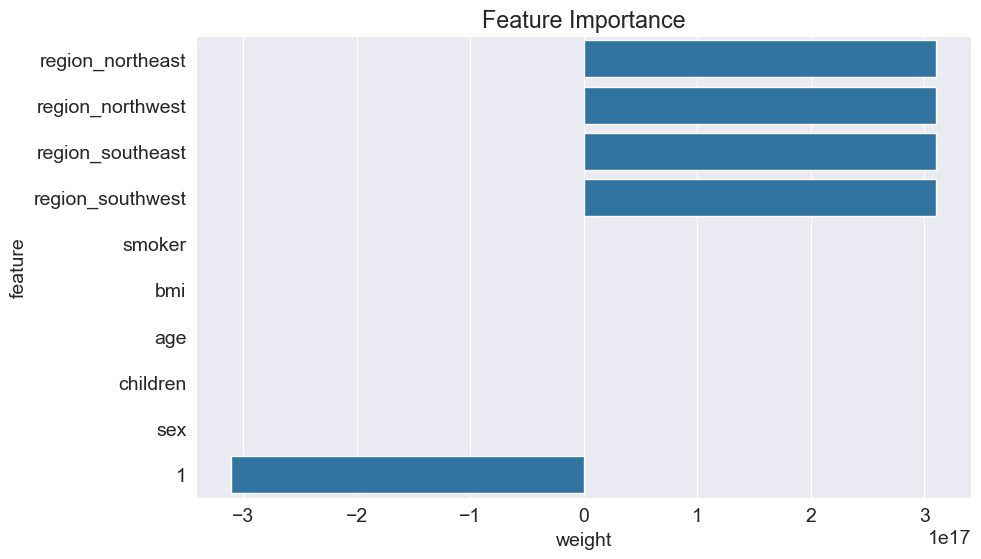

In [152]:
plt.title('Feature Importance')
sns.barplot(x=feature_importance['weight'], y=feature_importance['feature']);

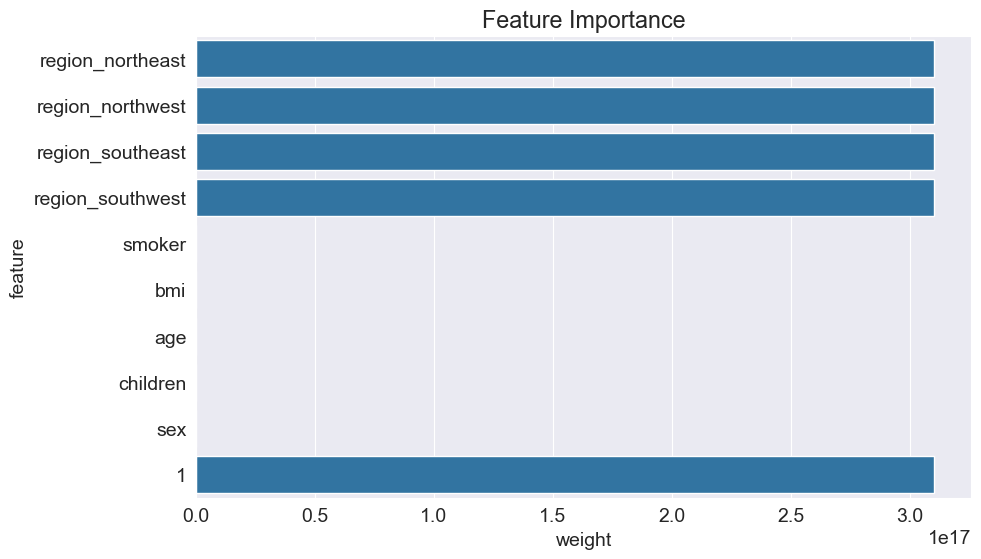

In [282]:
plt.title('Feature Importance')
sns.barplot(x=abs(feature_importance['weight']), y=feature_importance['feature']);

**The region Feature has the same effect for all regions and equals in magnitude and opposit to the model's Intercept**

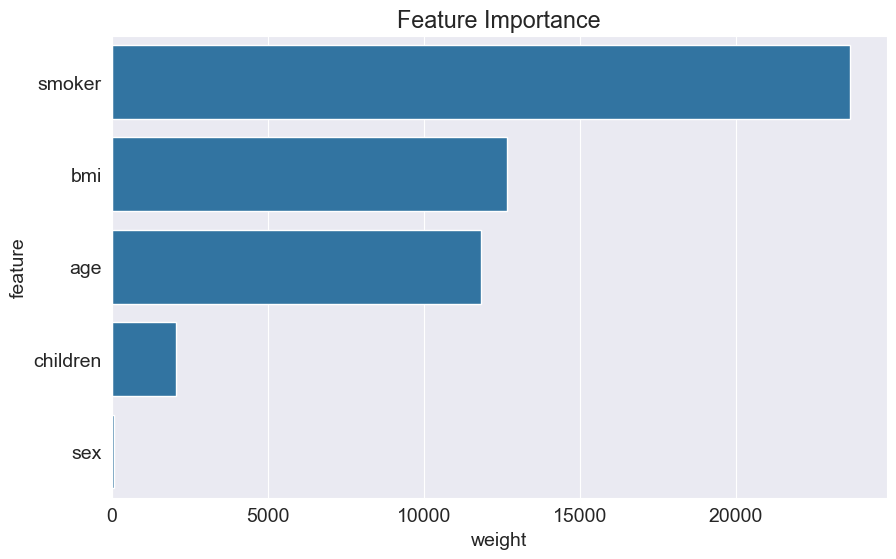

In [153]:
feature_importance=feature_importance.iloc[4:9]
plt.title('Feature Importance')
sns.barplot(x=abs(feature_importance['weight']), y=feature_importance['feature']);

>**As the effect of the 'region' column is canceled by the intercept, Among the remaining features, 'smoker', 'bmi', and 'age' are the most important features.**


### Save all the required objects and the trained model

> We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk. 


**Let's first create a dictionary containing all the required objects and save them**.

In [156]:
import joblib

In [157]:
req_objects = {
    'linear_model':linear_model,
   'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols,
    'Final_input_cols': Final_input_cols
}

**Save this to a file using joblib.dump**

In [158]:
joblib.dump(req_objects, 'req_objects.joblib')

['req_objects.joblib']

**Loaded back using joblib.load**

In [159]:
req_objects = joblib.load('req_objects.joblib')

**Extract them for feature use in their original form**

In [160]:
linear_model =   req_objects['linear_model']
imputer =   req_objects['imputer']
scaler  =  req_objects['scaler']
encoder  =  req_objects['encoder']
input_cols  =  req_objects['input_cols']
target_col  =  req_objects['target_col']
numeric_cols  =  req_objects['numeric_cols']
categorical_cols  = req_objects['categorical_cols']
encoded_cols  = req_objects['encoded_cols'] 
Final_input_cols= req_objects['Final_input_cols']

**verify that things are loaded in the right way by using the loaded model**

In [161]:
pred=linear_model.predict(X_test)
rmse=root_mean_squared_error(test_targets,pred)
rmse

5801.488334171705

> we get the saame result which shows that we can load and use the model any where.

## Making Predictions on a Single Input

Now we have the trained model which can be used to make predictions on new data. 

**Let's define a helper function to make predictions for individual inputs.**

In [162]:
def single_input_prediction(model,single_input):
    input_df = pd.DataFrame([single_input])
    input_df['sex']= input_df['sex'].map({'female':0,'male':1})
    input_df['smoker']= input_df['sex'].map({'no':0,'yes':1})
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    #prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred

In [165]:
# define an input in the following  format
new_input = {'age': 40,
             'sex': 'female',
             'bmi': 20,
             'children': 2,
             'smoker': 'no',
             'region': 'northwest'
            }

In [164]:
# make prediction
single_input_prediction(linear_model,new_input)

10304.0

**Change the age in the above inpute and see the new models prediction**

In [166]:
# define an input in the following  format
new_input = {'age': 20,
             'sex': 'female',
             'bmi': 20,
             'children': 2,
             'smoker': 'no',
             'region': 'northwest'
            }

In [167]:
# make prediction
single_input_prediction(linear_model,new_input)

5184.0

## Conclusion

We aim to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

> The historical data contains over 1300 entries and 7 features/columns.
> 
> The trained model has a performance RMSE = 5801.49 and r2_score = 78%

> The trained model with all features has a performance RMSE = 5801.49 which is about half of the model performance with 'age' as the input feature( RMSE=11661.22 )
>
> The model that uses all features as its input explains 78% of the target variance and the one that uses 'age' as its input feature explains only 8% of the target variance.
> 
> The three most important features are 'smoker', 'bmi', and 'age' 